# Result comparaison for Superpixels Entropy

In [51]:
import numpy as np
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data

from SSGA import SSGA

In [52]:
usedDataset = Data.IndianPines
#usedDataset = PaviaUniversity
#usedDataset = PaviaCenter

N,M,B = usedDataset["shape"]
N,M,B = usedDataset["data"].shape

def computePs(K):
    gamma = 0.15
    return int(N*M/K * 1/np.log(np.log(N*M/K)) * gamma)

## Finding $\lambda$ coefficient

### Theory

#### Similarity function

See hyperspectral image of dimension $(N,M,B)$ has a 8-connected graph with nodes being all $N\times M$ spectral vectors.

Let $s$ be the similarity function, originally,
$$s(x,y) = d(x,y)\bigg|\frac{1}{B} \underset{b=1}{\overset{B}{\sum}} x_b - y_b\bigg|$$
with
$$d(x,y) = \begin{cases}
1 & \text{If x and y are nex to each other}\\
\frac{1}{\sqrt{2}} & \text{Otherwise}
\end{cases}$$

The complete similarity function is
$$S(x,y) = e^{-\frac{1}{\sigma^2} s(x,y)}$$
With $\sigma = 1$.



For an edge $e$, we denote by $e.u$ and $e.v$ its two related nodes. For a edge $e$ a node $u$, the weight of $e$ and $u$ is:
$$TW = \underset{u}{\sum}\; \underset{\text{or } e.v=u}{\underset{e:e.u=u}{\sum}} S(e.u, e.v)$$
$$e.w = \frac{1}{TW} S(e.u, e.v)$$
$$u.w = \frac{1}{TW} \underset{\text{or } e.v=u}{\underset{e:e.u=u}{\sum}} e.w$$

#### Gain

Weight on edes (gain) at beginning:
$$Gain(e) = ERG(e) + A.BG(N\times M,\; 1,\; 1)$$
with
$$ERG(e) = ERG(e.w,\; e.u.w\;, e.v.w\;)$$

$$ERG(w, a, b) = \frac{1}{log(2)}
\begin{cases}
(w+a)log(w+a) + (w+b)log(w+b) -alog(a) -blog(b) -2wlog(w) & \text{if well defined}\\
0 & \text{otherwise}
\end{cases}
$$
being the similarity weight part,
$$ BG(N, a, b) = \frac{1}{log(2)}\left(-(a+b).log(a+b) + a.log(a) + b.log(b)\right)  +1 $$
being the balancing part,
$$ A = \lambda \frac{\underset{e \in Edges}{max}\;ERG(e)}{|BG(N\times M,\; 1,\; 1)|}$$
being the balancing term

When actualized, the gain is:
$$Gain(e) = ERG(e.w,\; e.u.w-e.w\; e.v.w-e.w) + A.BG(N\times M,\; |cc(e.u)|,\; |cc(e.v)|)$$
with $cc(u)$ being all the nodes in the connex componant of $u$.

#### Choice of \lambda

The goal is to let the more possibility of choice in SP without having to small hyperpixel.
$$ P_S = \frac{N\times M}{K} \frac{1}{log^2(\frac{N\times M}{K})} \gamma$$
with $\gamma = 0.15$ is the minimal size allowed for a superpixel.

Then, we want minimal $\lambda$ such that all superpixels computed with $\lambda$ are of size at least $P_S$.

### Implementation

In [53]:
def find_lambda_coeff(data, K, mini, maxi, similarity_function, Ps, print_info=False):
    def aux(i,j, SP):
        coeff = int((i+j)/2)
        if print_info:
            print("finding lambda coeff:", coeff)
        if i>=j:
            return SP, max(coeff,1)
        
        SP = ERS.find_superpixel(data, K, coeff, similarity_function)
        minSPsize = min([len(l) for l in SP])
        if minSPsize==Ps:
            return SP, coeff
        elif minSPsize<Ps:
            return aux(coeff+1, j, SP)
        else:
            return aux(i, coeff-1, SP)
        
    return aux(mini, maxi, None)

In [71]:
class Superpixel:
    def __init__(self, liste, labels, gt):
        self.pixels = [elt for elt in liste]
        self.guess = -1
        self.guess_count = 0

        for l in labels:
            guess_count = len(
                [i for i in range(len(self.pixels)) if gt[self.pixels[i]]==l]
            )
            if guess_count > self.guess_count:
                self.guess_count = guess_count
                self.guess = l

    def proportion(self):
        return self.guess_count/len(self.pixels)
    
    def is_single_class(self):
        return self.guess_count == len(self.pixels)
    

class SuperpixelClassifier:
    def __init__(self, liste, labels, gt):
        self.liste = liste
        self.SPs:list[Superpixel] = [Superpixel(l, labels, gt) for l in liste]
        self.association:dict[tuple[int,int], Superpixel] = {}

        for i,SP in enumerate(self.SPs):
            for coor in SP.pixels:
                self.association[coor] = i

    
    def getSP(self, x,y):
        return self.association[(x,y)]
    
    def guess(self, x,y):
        return self.getSP(x,y).guess

    def predict(self, liste):
        return [self.guess(coor) for coor in liste]
    
    def accuracy(self, samples, labels):
        assert len(samples)==len(labels)
        prediction = self.predict(samples)
        return len([i for i in range(len(samples)) if prediction[i]==labels[i]])
    
    def singleClassCount(self):
        return len([i for i in range(len(self.SPs)) if self.SPs[i].is_single_class()])
    
    def averageProportion(self):
        return np.average([SP.proportion() for SP in self.SPs])

### Comparing function

Superpixel computation time + SSGA computation times
Average SSGA final fitness function score
OA of SP classifier models
Number of 1-class SP
average proportion of max_amount/amount

## Comparing data change

In [55]:
data1 = usedDataset["data"].copy()
data2 = Data.normalized_data(usedDataset["data"].copy())
data3 = Data.standardize_data( usedDataset["data"].copy() )
datas = [data1, data2, data3]
names = ["Basic", "Normalized", "Standardized"]

In [66]:
K = 200
Ps = computePs(K)
# Values found with find_lambda_coeff function
lambdaCoeffDatas = {100:[1, 17, 34],
                    200:[1, 33, 72],
                    300:[1, 52, 110],
                    400:[1, 59, 150],
                    500:[1, 78, 187],
                    600:[1, 94, 230],
                    700:[1, 133, 275]}


SPClassifiers:list[SuperpixelClassifier] = []
for i,data in enumerate(datas):
    #SPs, coeff = find_lambda_coeff(data, K, 1, 300, ERS.complete_basic_similarity, Ps)
    #print("Choosen Coef:", coeff)
    SPs = ERS.find_superpixel(data, K, lambdaCoeffDatas[K][i], ERS.complete_basic_similarity, True)
    SPClassifiers.append(SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"]))

### Visual result

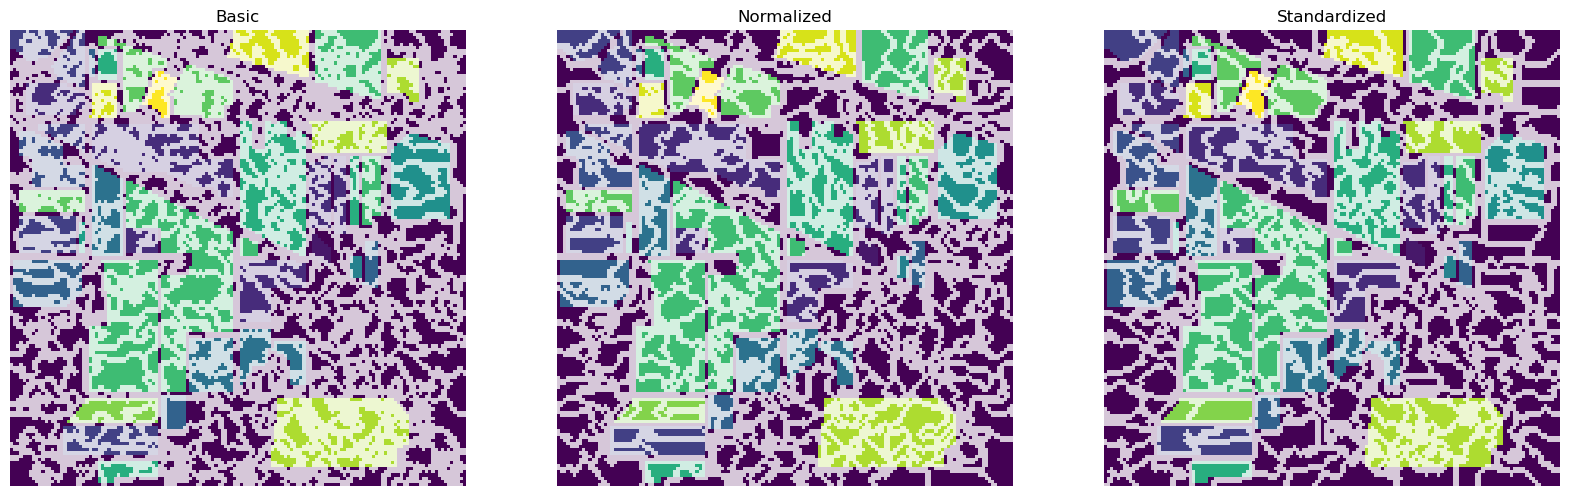

In [67]:
fig, axs = plt.subplots(1, len(SPClassifiers))
fig.set_size_inches(20,40)
for i,C in enumerate(SPClassifiers):
    axs[i].imshow(usedDataset["gt"])
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], C.liste, color=[255,255,255,200]))
    axs[i].title.set_text(names[i])
    axs[i].axis("off")

plt.show()

### Classification result

In [72]:
coordinates = [(x,y) for x in range(N) for y in range(M)]
labels = [usedDataset["gt"][coor] for coor in coordinates]
infos = [[] for _ in range(len(datas))]
for i,C in enumerate(SPClassifiers):
    infos[i] = [
        C.accuracy(coordinates, labels),
        C.singleClassCount(),
        C.averageProportion()
    ]
infos.insert(0, ["OA", "SingleClassCount", "AverageProportion"])

TypeError: 'method' object is not subscriptable

### Time result

In [ ]:
import time

class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

Ks = [100*i for i in range(1,8)]

SPs_time = {K:[0 for _ in range(len(datas))] for K in Ks}
SSGA_time = {K:[0 for _ in range(len(datas))] for K in Ks}
best_fitness = {K:[0 for _ in range(len(datas))] for K in Ks}

A = 10
for K in Ks:
    print("K:", K)
    for i,data in enumerate(datas):
        for _ in range(A):
            start_time = time.time()
            SPs = ERS.find_superpixel(data, K, lambdaCoeffDatas[K][i], ERS.complete_basic_similarity, True)
            end_time = time.time()
            SPs_time[K][i] += end_time - start_time

            start_time = time.time()
            pop, fitness = SSGA(data, 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2, False, SP=SPs)
            end_time = time.time()
            SSGA_time[K][i] += end_time - start_time
            best_fitness[K][i] += fitness[0]
        
        SPs_time[K][i] /= A
        SSGA_time[K][i] /= A
        best_fitness[K][i] /= A

K: 100
K: 200
K: 300
K: 400
K: 500
K: 600
K: 700


In [73]:
print(SPs_time)
print(SSGA_time)
print(best_fitness)

{100: [10.692700862884521, 9.697648048400879, 9.004975080490112], 200: [9.445805788040161, 10.824516773223877, 9.774529695510864], 300: [9.545434713363647, 10.7208092212677, 9.916143655776978], 400: [9.229990482330322, 11.50728440284729, 10.779298543930054], 500: [8.982416868209839, 10.320045709609985, 10.094208002090454], 600: [8.477921962738037, 11.339497566223145, 10.252572059631348], 700: [8.04901671409607, 10.851320266723633, 10.928387641906738]}
{100: [2.7420356273651123, 2.492100954055786, 2.7677788734436035], 200: [2.5874111652374268, 3.093327522277832, 2.8952524662017822], 300: [2.666292190551758, 2.435565710067749, 2.8165204524993896], 400: [3.077873468399048, 2.742413282394409, 2.8139145374298096], 500: [2.9696226119995117, 2.6409835815429688, 2.443225622177124], 600: [3.043376922607422, 2.791020631790161, 2.7960140705108643], 700: [2.773719310760498, 2.6540701389312744, 3.0260767936706543]}
{100: [0.564900801139824, 0.6700809343838839, 0.7393010052240507], 200: [0.647883284

{100: [10.692700862884521, 9.697648048400879, 9.004975080490112], 200: [9.445805788040161, 10.824516773223877, 9.774529695510864], 300: [9.545434713363647, 10.7208092212677, 9.916143655776978], 400: [9.229990482330322, 11.50728440284729, 10.779298543930054], 500: [8.982416868209839, 10.320045709609985, 10.094208002090454], 600: [8.477921962738037, 11.339497566223145, 10.252572059631348], 700: [8.04901671409607, 10.851320266723633, 10.928387641906738]}

{100: [2.7420356273651123, 2.492100954055786, 2.7677788734436035], 200: [2.5874111652374268, 3.093327522277832, 2.8952524662017822], 300: [2.666292190551758, 2.435565710067749, 2.8165204524993896], 400: [3.077873468399048, 2.742413282394409, 2.8139145374298096], 500: [2.9696226119995117, 2.6409835815429688, 2.443225622177124], 600: [3.043376922607422, 2.791020631790161, 2.7960140705108643], 700: [2.773719310760498, 2.6540701389312744, 3.0260767936706543]}

{100: [0.564900801139824, 0.6700809343838839, 0.7393010052240507], 200: [0.647883284355866, 0.7732146542294418, 0.8355649330310471], 300: [0.711928252130091, 0.7918464795046569, 0.84757043129747], 400: [0.7315903055051772, 0.8247767741744884, 0.88854362096494], 500: [0.7803511774918824, 0.828399834405302, 0.8930534182039617], 600: [0.7826777936616738, 0.8610360652046352, 0.8849423910323988], 700: [0.8123070428393724, 0.8669709352875258, 0.8904057407446652]}

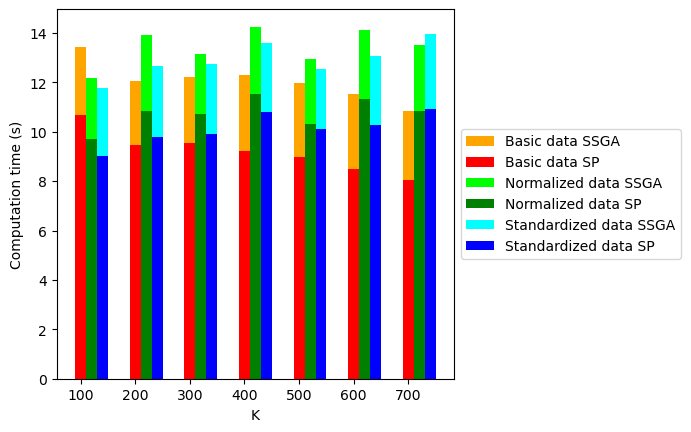

In [106]:
SP_colors = ["red", "green", "blue"]
SSGA_colors = ["orange", "lime", "cyan"]


fig = plt.figure()
ax = plt.subplot(111)
for k,K in enumerate(Ks):
    for d,data in enumerate(datas):
        if k==0:
            ax.bar(K+d*20, SPs_time[K][d]+SSGA_time[K][d], width=20, color=SSGA_colors[d], label=names[d]+" data SSGA")
            ax.bar(K+ d*20, SPs_time[K][d], color=SP_colors[d], width=20, label=names[d]+" data SP")
        else:
            ax.bar(K+d*20, SPs_time[K][d]+SSGA_time[K][d], width=20, color=SSGA_colors[d])
            ax.bar(K+ d*20, SPs_time[K][d], color=SP_colors[d], width=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("K")
plt.ylabel("Computation time (s)")
plt.show()

### Comparing similarity function

In [58]:
K = 700
print(N,M, B)
print(N*M, K, N*M/K)

gamma = 0.15
Ps = N*M/K * 1/np.log(np.log(N*M/K)) * gamma
print(Ps)
Ps =  int(Ps)

145 145 200
21025 700 30.035714285714285
3.6794125840283103


In [59]:
"""
SP, coeff = find_lambda_coeff(usedDataset["data"], K, 1, 1000, complete_basic_similarity, Ps)
print(coeff)
SP1_overlay = create_overlay_borders(usedDataset["data"][:,:,0], SP)
l = [len(l) for l in SP]
l.sort()
print(l)
"""

'\nSP, coeff = find_lambda_coeff(usedDataset["data"], K, 1, 1000, complete_basic_similarity, Ps)\nprint(coeff)\nSP1_overlay = create_overlay_borders(usedDataset["data"][:,:,0], SP)\nl = [len(l) for l in SP]\nl.sort()\nprint(l)\n'

In [60]:
SP2, coeff2 = find_lambda_coeff(usedDataset["data"], K, 10, 500, ERS.complete_norm_similarity, Ps)
print(coeff2)
SP2_overlay = ERS.create_overlay_borders(usedDataset["data"][:,:,0], SP2)
l = [len(l) for l in SP2]
l.sort()
print(l)

/home/maceo/Documents/Internships/M1/M1-internship-SSGA/code/EntropyRateSuperpixel.py:145: RuntimeWarning: invalid value encountered in scalar divide
  e.w /= total_weight
/home/maceo/Documents/Internships/M1/M1-internship-SSGA/code/EntropyRateSuperpixel.py:147: RuntimeWarning: invalid value encountered in divide
  return loops/total_weight, edges, total_weight


KeyboardInterrupt: 

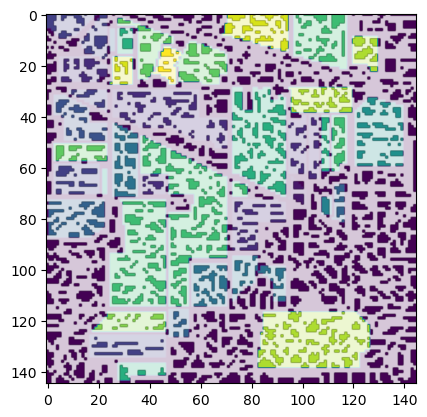

In [ ]:
b = np.random.randint(0, B-1)

overlays = [SP2_overlay]
color = [255,255,255,200]
for k in range(len(overlays)):
    for i in range(N):
        for j in range(M):
            if overlays[k][i,j][3] != 0:
                overlays[k][i,j] = color
    
    plt.imshow(usedDataset["gt"])
    plt.imshow(overlays[k])

plt.show()